In [1]:
import pandas as pd 
from data_loading import load_tabular_data, preprocess_data
from NN import NN
import torch
import numpy as np
from matplotlib import pyplot as plt
#from torchmetrics import JaccardIndex
import seaborn as sbn
from sklearn.metrics import roc_auc_score
from GenDataset import GenDataset
from DVGS import DVGS
from DVRL import DVRL
import time


%load_ext autoreload
%autoreload 2

/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
noise_idx = load_tabular_data('adult', {'train':1000, 'valid':400}, noise_rate=0.2) # saves to disk
x_train, y_train, x_valid, y_valid, x_test, y_test, col_names = preprocess_data('minmax', 'train.csv', 'valid.csv', 'test.csv')
train_dataset = GenDataset(x_train, y_train)
test_dataset = GenDataset(x_test, y_test)
valid_dataset = GenDataset(x_valid, y_valid)

In [23]:
model = NN(in_channels=108, out_channels=1, num_layers=1, hidden_channels=100, norm=False, dropout=0., bias=True, act=torch.nn.ReLU, out_fn=torch.nn.Sigmoid())
dvgs = DVGS(train_dataset, valid_dataset, test_dataset, model)
#dvgs.pretrain_(crit=torch.nn.BCELoss(), num_workers=1, batch_size=256, lr=1e-3, epochs=25)
print()

tic = time.time() 
vals_dvgs, grad_mag = dvgs.run(crit          = torch.nn.BCELoss(), 
                    similarity     = torch.nn.CosineSimilarity(dim=1), 
                    optim          = torch.optim.Adam, 
                    lr             = 1e-2, 
                    num_epochs     = 100, 
                    compute_every  = 1, 
                    batch_size     = 512, 
                    num_workers    = 1, 
                    grad_params    = None, 
                    verbose        = True, 
                    use_cuda       = True)
print()
print(f'time elapsed: {(time.time() - tic)/60:.2f} min')



using device: cuda
epoch 99 || avg loss: 0.05 || grad time elapsed: 0.1 s0.0094s/batch)
time elapsed: 0.23 min


In [75]:
pred = NN(in_channels=108, out_channels=2, num_layers=2, hidden_channels=100, norm=True, dropout=0., bias=True, act=torch.nn.ReLU, out_fn=torch.nn.Softmax(dim=-1))
est = NN(in_channels=111, out_channels=1, num_layers=5, hidden_channels=100, norm=True, dropout=0.1, bias=True, act=torch.nn.ReLU, out_fn=None)

dvrl = DVRL(train_dataset, valid_dataset, test_dataset, predictor=pred, estimator=est)
CEL = torch.nn.CrossEntropyLoss() 
#dvrl.predictor = dvrl.pretrain(model=dvrl.predictor, dataset=dvrl.train, crit=lambda x,y: CEL(x,y.squeeze(1).type(torch.long)), epochs=100, lr=1e-3)
print()

tic = time.time() 
vals_dvrl = dvrl.run(perf_metric            = 'auroc', 
                     crit_pred              = lambda x,y: CEL(x,y.squeeze(1).type(torch.long)), 
                     outer_iter             = 2000, 
                     inner_iter             = 200, 
                     outer_batch            = 2000, 
                     outer_workers          = 1, 
                     inner_batch            = 256, 
                     estim_lr               = 1e-2, 
                     pred_lr                = 1e-3, 
                     moving_average_window  = 20,
                     exploration_weight     = 1e-3, 
                     exploration_threshold  = 0.9,
                     fix_baseline           = True)
print()
print(f'time elapsed: {(time.time() - tic)/60:.2f} min')


pretraining `ori_model` and `val_model` 


Exception ignored in: <function _releaseLock at 0x7fd496531310>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


(array([ 58., 226., 149.,  64.,  36.,  46.,  62., 119., 155.,  85.]),
 array([-12.034671  ,  -9.603791  ,  -7.1729116 ,  -4.742032  ,
         -2.3111525 ,   0.11972713,   2.5506067 ,   4.9814863 ,
          7.412366  ,   9.8432455 ,  12.274125  ], dtype=float32),
 <BarContainer object of 10 artists>)

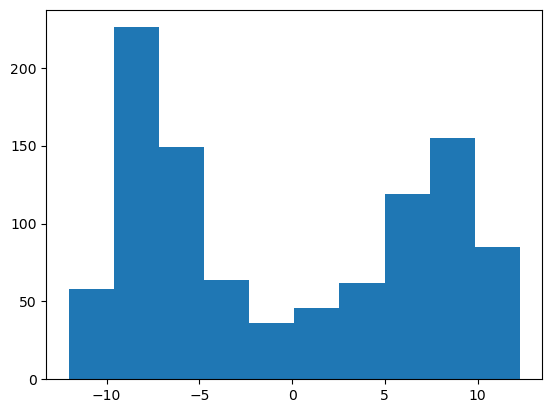

In [73]:
plt.hist(vals_dvrl.view(-1).detach().cpu().numpy())

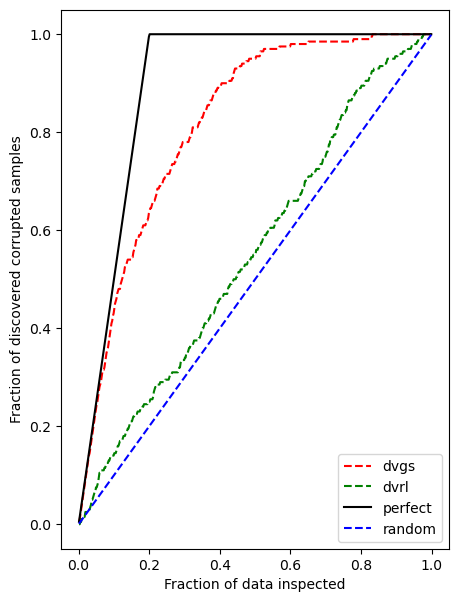

In [74]:
ks = np.linspace(1,999,500)
n_dvgs = []
n_dvrl = []
n_perfect = [] 
n_random = [] 


for k in ks: 
    idx_dvgs = np.argpartition(vals_dvgs.mean(axis=1), int(k))[:int(k)]
    idx_dvrl = np.argpartition(vals_dvrl.detach().cpu().numpy().ravel(), int(k))[:int(k)]
    n_dvgs.append( len(set(noise_idx).intersection(set(idx_dvgs)))/200 ) 
    n_dvrl.append( len(set(noise_idx).intersection(set(idx_dvrl)))/200 ) 
    n_perfect.append(min(int(k), 200)/200)
    n_random.append(k*0.2/200)

plt.figure(figsize=(5, 7))
plt.plot(ks/1000, n_dvgs, 'r--', label='dvgs')
plt.plot(ks/1000, n_dvrl, 'g--', label='dvrl')
plt.plot(ks/1000, n_perfect, 'k-', label='perfect')
plt.plot(ks/1000, n_random, 'b--', label='random')
plt.legend()
plt.ylabel('Fraction of discovered corrupted samples')
plt.xlabel('Fraction of data inspected')
plt.show()

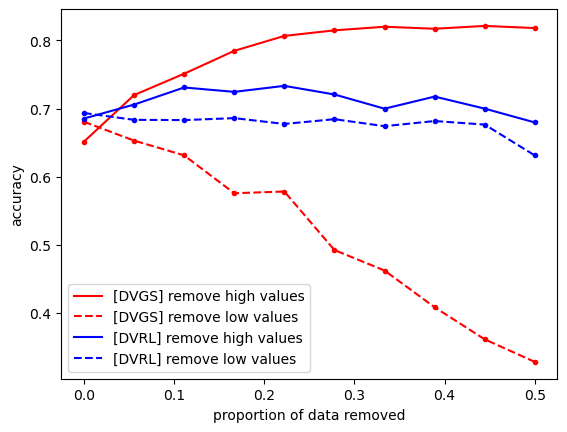

In [59]:
def train_model(x_train, y_train, x_test, y_test, epochs=200): 

    model = NN(in_channels=108, out_channels=1, num_layers=2, hidden_channels=100, norm=True, dropout=0.1, bias=True, act=torch.nn.ReLU, out_fn=torch.nn.Sigmoid)

    crit = torch.nn.BCELoss()
    optim = torch.optim.Adam(model.parameters())

    for epoch in range(epochs): 

        optim.zero_grad()
        yhat_train = model(x_train).squeeze()
        loss = crit(yhat_train, y_train)
        loss.backward()
        optim.step()

    yhat_test = 1. * (model(x_test).detach().numpy() > 0.5).ravel()
    y_test = y_test.detach().numpy().ravel()

    acc = (yhat_test == y_test).sum() / y_test.shape[0]

    return acc

### 

def get_perf_curve(dvs, ks, epochs=500): 
    acc_low = []
    acc_high = []
    for k in ks: 
        print(int(k), end='\r')
        sorted_idx = np.argsort(dvs)

        high_idxs = sorted_idx[0:(1000-int(k))]
        low_idxs = sorted_idx[(int(k)):]

        acc_low.append(train_model(torch.tensor(x_train[high_idxs, :], dtype=torch.float32), torch.tensor(y_train[high_idxs], dtype=torch.float32), torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32), epochs=epochs))
        acc_high.append(train_model(torch.tensor(x_train[low_idxs, :], dtype=torch.float32), torch.tensor(y_train[low_idxs], dtype=torch.float32), torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32), epochs=epochs))

    return acc_low, acc_high

ks = np.linspace(0,500,10)
dvgs_low, dvgs_high = get_perf_curve(vals_dvgs.mean(axis=1), ks)
dvrl_low, dvrl_high = get_perf_curve(vals_dvrl.detach().cpu().numpy().ravel(), ks)



plt.figure()
plt.plot(ks/1000, dvgs_high, 'r-', label='[DVGS] remove high values')
plt.plot(ks/1000, dvgs_high, 'r.',)
plt.plot(ks/1000, dvgs_low, 'r--', label='[DVGS] remove low values')
plt.plot(ks/1000, dvgs_low, 'r.')

plt.plot(ks/1000, dvrl_high, 'b-', label='[DVRL] remove high values')
plt.plot(ks/1000, dvrl_high, 'b.',)
plt.plot(ks/1000, dvrl_low, 'b--', label='[DVRL] remove low values')
plt.plot(ks/1000, dvrl_low, 'b.')

plt.legend()
plt.xlabel('proportion of data removed')
plt.ylabel('accuracy')
plt.show()

In [ ]:
dist = torch.distributions.Bernoulli(torch.tensor([0.1, 0.3, 0., 0.99]))

In [ ]:
dist.sample()

tensor([0., 0., 0., 1.])

In [ ]:
sim_vals1 = sim_vals

In [ ]:
c = np.zeros((1000))
c[noise_idx] = 1
res = pd.DataFrame({'dv1':sim_vals.mean(axis=1), 'dv2':sim_vals1.mean(axis=1), 'corrupted':c})
#res.head()
res.corr('spearman')

NameError: name 'sim_vals1' is not defined

In [ ]:
plt.figure()
sbn.scatterplot(x='dv1', y='dv2', hue='corrupted', data=res)
plt.show()

NameError: name 'res' is not defined

<Figure size 640x480 with 0 Axes>

In [ ]:
sim_vals = vals_dvgs

In [ ]:
c_true = np.ones(1000, dtype=float)
c_true[noise_idx] = 0.
aucs = []
for i in range(sim_vals.shape[1]): 
    x = sim_vals[:, i]
    z = (x - min(x))/(max(x) - min(x))
    aucs.append( roc_auc_score(c_true, z) )

    

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

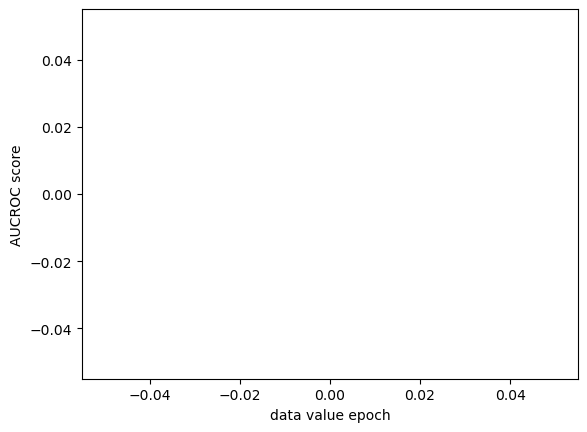

In [ ]:
plt.figure()
plt.plot(aucs)
plt.xlabel('data value epoch')
plt.ylabel('AUCROC score')
plt.show()

In [ ]:
not_noise_idx = np.delete(np.arange(1000), noise_idx)

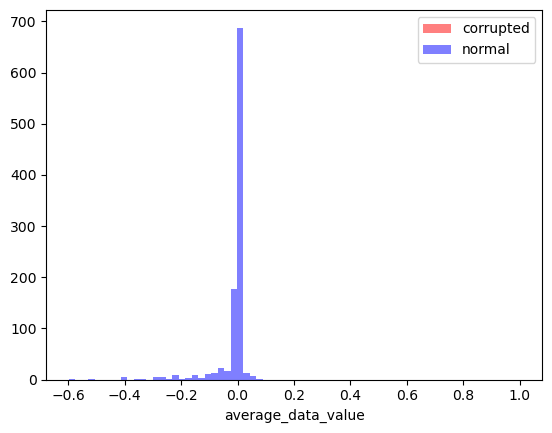

In [ ]:
plt.figure()
plt.hist(sim_vals.mean(axis=1)[noise_idx], color='r', label='corrupted', alpha=0.5, bins=30)
plt.hist(sim_vals.mean(axis=1)[not_noise_idx], color='b', label='normal', alpha=0.5, bins=30)
plt.xlabel('average_data_value')
plt.legend()
plt.show()

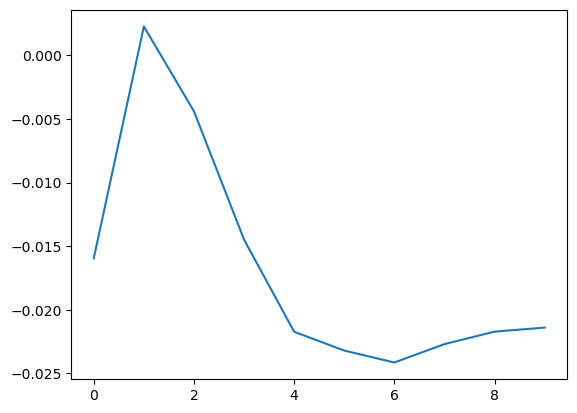

In [ ]:
plt.figure()
plt.plot(sim_vals.mean(axis=0))
plt.show()

/tmp/ipykernel_3791/2330010559.py:6: RuntimeWarning: Mean of empty slice.
  plt.plot(sim_vals[noise_idx, :].T.mean(axis=1), color='r', alpha=1., label='corrupted')
/home/teddy/miniconda3/envs/dvrl/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


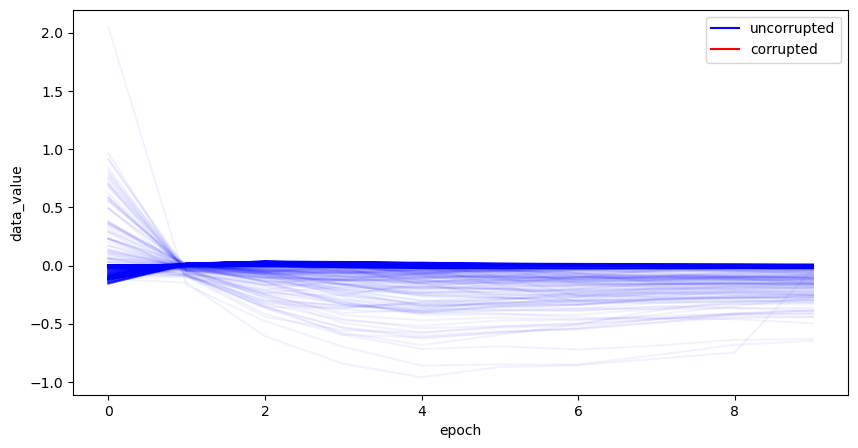

In [ ]:
sim_vals = vals_dvgs
plt.figure(figsize=(10,5))
plt.plot(sim_vals[noise_idx, :].T, color='r', alpha=0.1)
plt.plot(sim_vals[not_noise_idx, :].T, color='b', alpha=0.05)
plt.plot(sim_vals[not_noise_idx, :].T.mean(axis=1), color='b', alpha=1., label='uncorrupted')
plt.plot(sim_vals[noise_idx, :].T.mean(axis=1), color='r', alpha=1., label='corrupted')
plt.xlabel('epoch')
plt.ylabel('data_value')
plt.legend()
plt.show()

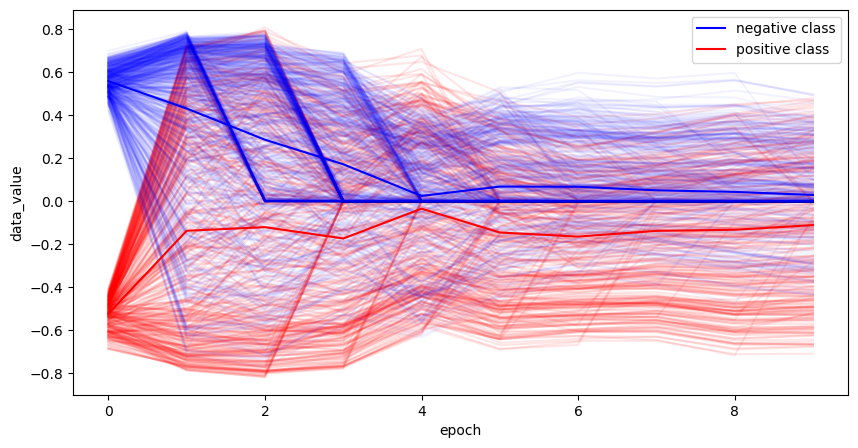

In [ ]:
pos_idx = y_train.nonzero()[0].ravel()
neg_idx = np.delete(np.arange(1000), pos_idx)

plt.figure(figsize=(10,5))
plt.plot(sim_vals[pos_idx, :].T, color='r', alpha=0.1)
plt.plot(sim_vals[neg_idx, :].T, color='b', alpha=0.05)
plt.plot(sim_vals[neg_idx, :].T.mean(axis=1), color='b', alpha=1., label='negative class')
plt.plot(sim_vals[pos_idx, :].T.mean(axis=1), color='r', alpha=1., label='positive class')
plt.xlabel('epoch')
plt.ylabel('data_value')
plt.legend()
plt.show()

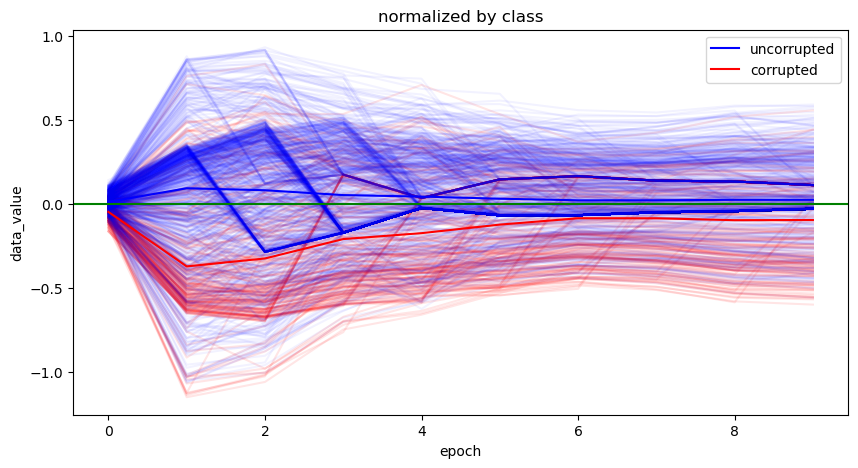

In [ ]:
pos_avg_sim = sim_vals[pos_idx, :].mean(axis=0)
neg_avg_sim = sim_vals[neg_idx, :].mean(axis=0)

sim_vals2 = sim_vals.copy()
sim_vals2[pos_idx, :] -= pos_avg_sim.reshape(-1,1).T
sim_vals2[neg_idx, :] -= neg_avg_sim.reshape(-1,1).T

plt.figure(figsize=(10,5))
plt.plot(sim_vals2[noise_idx, :].T, color='r', alpha=0.1)
plt.plot(sim_vals2[not_noise_idx, :].T, color='b', alpha=0.05)
plt.plot(sim_vals2[not_noise_idx, :].T.mean(axis=1), color='b', alpha=1., label='uncorrupted')
plt.plot(sim_vals2[noise_idx, :].T.mean(axis=1), color='r', alpha=1., label='corrupted')
plt.xlabel('epoch')
plt.ylabel('data_value')
plt.title('normalized by class')
plt.legend()
plt.axhline(0, color='g')
plt.show()

In [ ]:

ks = np.linspace(1,500,500)
n_corrupt = []
n_perfect = [] 
n_random = [] 

dvs = sim_vals.mean(axis=1)
for k in ks: 
    idx = np.argpartition(dvs, int(k))[:int(k)]
    n_corrupt.append( len(set(noise_idx).intersection(set(idx)))/200 ) 
    n_perfect.append(min(int(k), 200)/200)
    n_random.append(k*0.2/200)

plt.figure(figsize=(5, 7))
plt.plot(ks/1000, n_corrupt, 'r--', label='dvgs')
plt.plot(ks/1000, n_perfect, 'k-', label='perfect')
plt.plot(ks/1000, n_random, 'b--', label='random')
plt.legend()
plt.ylabel('Fraction of discovered corrupted samples')
plt.xlabel('Fraction of data inspected')
plt.show()

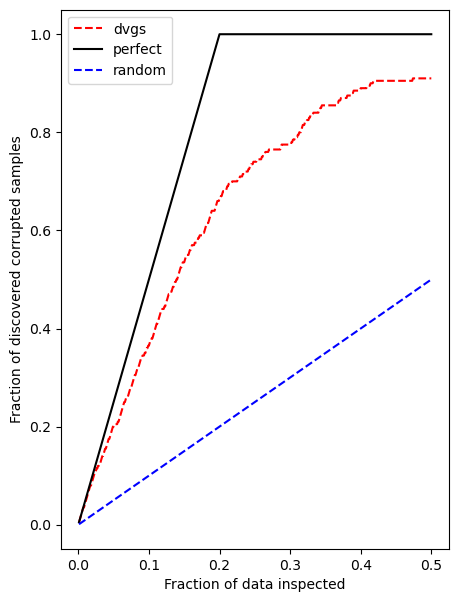

In [ ]:
plt.figure(figsize=(5, 7))
plt.plot(ks/1000, n_corrupt, 'r--', label='dvgs')
plt.plot(ks/1000, n_perfect, 'k-', label='perfect')
plt.plot(ks/1000, n_random, 'b--', label='random')
plt.legend()
plt.ylabel('Fraction of discovered corrupted samples')
plt.xlabel('Fraction of data inspected')
plt.show()

In [ ]:
def train_model(x_train, y_train, x_test, y_test, epochs=200): 

    model = NN(in_channels=108, out_channels=1, num_layers=1, hidden_channels=100, norm=False, dropout=0.1, bias=True, act=torch.nn.ReLU, out_fn=torch.nn.Sigmoid)

    crit = torch.nn.BCELoss()
    optim = torch.optim.Adam(model.parameters())

    for epoch in range(epochs): 

        optim.zero_grad()
        yhat_train = model(x_train).squeeze()
        loss = crit(yhat_train, y_train)
        loss.backward()
        optim.step()

    yhat_test = 1. * (model(x_test).detach().numpy() > 0.5).ravel()
    y_test = y_test.detach().numpy().ravel()

    acc = (yhat_test == y_test).sum() / y_test.shape[0]

    return acc

In [ ]:
ks = np.linspace(0,500,25)
dvs = sim_vals.mean(axis=1)
high_accs = []
low_accs = []

for k in ks: 
    print(int(k), end='\r')
    sorted_idx = np.argsort(dvs)

    high_idxs = sorted_idx[0:(1000-int(k))]
    low_idxs = sorted_idx[(int(k)):]


    high_accs.append(train_model(x_train[high_idxs, :], y_train[high_idxs], x_test, y_test, epochs=500))
    low_accs.append(train_model(x_train[low_idxs, :], y_train[low_idxs], x_test, y_test, epochs=500))


plt.figure()
plt.plot(ks/1000, high_accs, 'r-', label='remove high values')
plt.plot(ks/1000, high_accs, 'r.',)
plt.plot(ks/1000, low_accs, 'b-', label='remove low values')
plt.plot(ks/1000, low_accs, 'b.')
plt.legend()
plt.xlabel('proportion of data removed')
plt.ylabel('accuracy')
plt.show()

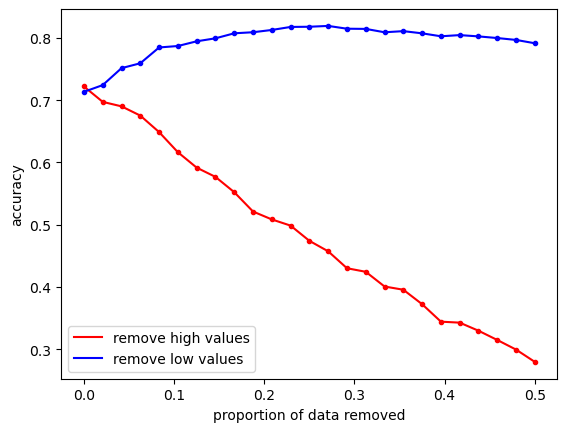

In [ ]:
plt.figure()
plt.plot(ks/1000, high_accs, 'r-', label='remove high values')
plt.plot(ks/1000, high_accs, 'r.',)
plt.plot(ks/1000, low_accs, 'b-', label='remove low values')
plt.plot(ks/1000, low_accs, 'b.')
plt.legend()
plt.xlabel('proportion of data removed')
plt.ylabel('accuracy')
plt.show()